# Importing main libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pyprind
import os
import sys

In [3]:
basepath = 'aclImdb'
labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000, stream=sys.stdout)

data = []


In [4]:
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        
        for file in sorted(os.listdir(path)):
            with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
                txt = infile.read()
            data.append([txt, labels[l]])
            
            pbar.update()


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


In [5]:
df = pd.DataFrame(data, columns=['review', 'sentiment'])

In [6]:
df

,review,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1
...,...,...
49995,"Towards the end of the movie, I felt it was to...",0
49996,This is the kind of movie that my enemies cont...,0
49997,I saw 'Descent' last night at the Stockholm Fi...,0
49998,Some films that you pick up for a pound turn o...,0


<Axes: xlabel='sentiment', ylabel='count'>

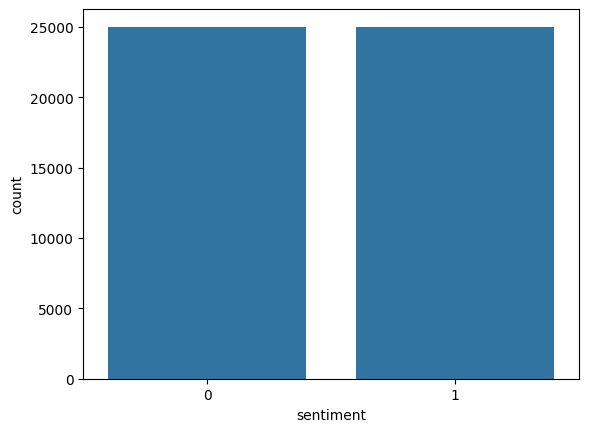

In [7]:
sns.countplot(df, x=df.sentiment)

In [8]:
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df.to_csv('movie_data.csv', index=False, encoding='utf-8')

In [3]:
df = pd.read_csv('movie_data.csv', encoding='utf-8')
df.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [4]:
df.shape

(50000, 2)

# Преобразование слов в векторы признаков

## Создание bag of words

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
countv = CountVectorizer()

In [6]:
docs = np.array(['The sun is shining', 'The weather is sweeet', 'The sun is shining, the weather is sweeet', 'and one and one is two'])
bag = countv.fit_transform(docs)

In [7]:
sorted(countv.vocabulary_.keys())

['and', 'is', 'one', 'shining', 'sun', 'sweeet', 'the', 'two', 'weather']

In [8]:
bag.toarray()

array([[0, 1, 0, 1, 1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 1, 0, 1],
       [0, 2, 0, 1, 1, 1, 2, 0, 1],
       [2, 1, 2, 0, 0, 0, 0, 1, 0]])

In [9]:
df_temp = pd.DataFrame(data=bag.toarray(), columns=sorted(countv.vocabulary_.keys()))
df_temp

,and,is,one,shining,sun,sweeet,the,two,weather
0,0,1,0,1,1,0,1,0,0
1,0,1,0,0,0,1,1,0,1
2,0,2,0,1,1,1,2,0,1
3,2,1,2,0,0,0,0,1,0


## Параметр ngram_range

In [10]:
countv = CountVectorizer(ngram_range=(2, 2))

In [11]:
docs = np.array(['The sun is shining', 'The weather is sweeet', 'The sun is shining, the weather is sweeet', 'and one and one is two'])
bag = countv.fit_transform(docs)

In [12]:
sorted(countv.vocabulary_.keys())

['and one',
 'is shining',
 'is sweeet',
 'is two',
 'one and',
 'one is',
 'shining the',
 'sun is',
 'the sun',
 'the weather',
 'weather is']

In [13]:
countv.vocabulary_

{'the sun': 8,
 'sun is': 7,
 'is shining': 1,
 'the weather': 9,
 'weather is': 10,
 'is sweeet': 2,
 'shining the': 6,
 'and one': 0,
 'one and': 4,
 'one is': 5,
 'is two': 3}

In [14]:
bag.toarray()

array([[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       [2, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]])

# Оценка релевантности слов с помощью частоты термина и обратной частоты документа TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)

In [16]:
np.set_printoptions(precision=2)
tfidf.fit_transform(countv.fit_transform(docs)).toarray()

array([[0.  , 0.58, 0.  , 0.  , 0.  , 0.  , 0.  , 0.58, 0.58, 0.  , 0.  ],
       [0.  , 0.  , 0.58, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.58, 0.58],
       [0.  , 0.36, 0.36, 0.  , 0.  , 0.  , 0.46, 0.36, 0.36, 0.36, 0.36],
       [0.76, 0.  , 0.  , 0.38, 0.38, 0.38, 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [17]:
df.loc[0, 'review'][-50:]

'is seven.<br /><br />Title (Brazil): Not Available'

In [18]:
import re

def preprocessor(text):
    text = re.sub(r'<[^>]*>', '', text)  # 1. Убираем HTML-теги
    emoticons = re.findall(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)  # 2. Находим смайлики
    text = (re.sub(r'[\W]+', ' ', text.lower()) +  # 3. Оставляем только буквы/цифры, в нижнем регистре
            ' '.join(emoticons).replace('-', ''))  # 4. Добавляем смайлики обратно (без дефисов)
    return text

In [19]:
preprocessor(df.loc[0, 'review'][-50:])

'is seven title brazil not available'

In [20]:
preprocessor("This is A TESt, :) is :( :-)!")

'this is a test is :) :( :)'

In [21]:
df['review'] = df['review'].apply(preprocessor)

# Получение токенов из документов

In [22]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [23]:
def tokinezer(text):
    return text.split()

tokinezer('runners like running and thus they run')

['runners', 'like', 'running', 'and', 'thus', 'they', 'run']

In [24]:
def tokinezer_ps(text):
    return [ps.stem(word) for word in text.split()]

tokinezer_ps('runners like running and thus they run')

['runner', 'like', 'run', 'and', 'thu', 'they', 'run']

In [25]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/ilgiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stop = stopwords.words('english')
[w for w in tokinezer_ps('a runner likes running and runs a lot') if w not in stop]

['runner', 'like', 'run', 'run', 'lot']

# Создание логистич. регрессии для классификации обзоров по средством мешка слов

In [27]:
X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

X_train

array(['in 1974 the teenager martha moxley maggie grace moves to the high class area of belle haven greenwich connecticut on the mischief night eve of halloween she was murdered in the backyard of her house and her murder remained unsolved twenty two years later the writer mark fuhrman christopher meloni who is a former la detective that has fallen in disgrace for perjury in o j simpson trial and moved to idaho decides to investigate the case with his partner stephen weeks andrew mitchell with the purpose of writing a book the locals squirm and do not welcome them but with the support of the retired detective steve carroll robert forster that was in charge of the investigation in the 70 s they discover the criminal and a net of power and money to cover the murder murder in greenwich is a good tv movie with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a kennedy the powerful and rich family used their influence to cover 

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
tdifd = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)
small_param_grid = [
    {
        'vect__ngram_range': [(1, 1)],
        'vect__stop_words': [None],
        'vect__tokenizer': [tokinezer, tokinezer_ps],
        'clf__penalty': ['l2'],
        'clf__C': [1.0, 10.0]
    },
    {
        'vect__ngram_range': [(1, 1)],
        'vect__stop_words': [stop, None],
        'vect__tokenizer': [tokinezer],
        'vect__use_idf': [False],
        'vect__norm': [None],
        'clf__penalty': ['l2'],
        'clf__C': [1.0, 10.0]
    }
]

In [30]:
lr_tfidf = Pipeline([
    ('vect', tdifd),
    ('clf', LogisticRegression(solver='liblinear'))
])

In [31]:
gs_lr_tfidf = GridSearchCV(estimator=lr_tfidf, param_grid=small_param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=1)

In [32]:
# gs_lr_tfidf.fit(X_train, y_train)

In [34]:
# f'Best params: {gs_lr_tfidf.best_params_:.3f}'

In [ ]:
# f'Accuracy: {gs_lr_tfidf.best_score_:.3f}'

# Онлайн обучение или обучение по частям

In [ ]:
import re


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')

In [35]:
def tokenizer_E(text):
    text = re.sub(r'<[^>]*>', '', text)  # 1. Убираем HTML-теги
    emoticons = re.findall(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)  # 2. Находим смайлики
    text = (re.sub(r'[\W]+', ' ', text.lower()) +  # 3. Оставляем только буквы/цифры, в нижнем регистре
            ' '.join(emoticons).replace('-', ''))  # 4. Добавляем смайлики обратно (без дефисов)
    
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

In [36]:
def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv)
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

In [37]:
next(stream_docs('movie_data.csv'))

('"In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />""Murder in Greenwich"" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich f

In [38]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [39]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

In [45]:
vect = HashingVectorizer(decode_error='ignore', n_features=2**21, preprocessor=None, tokenizer=tokenizer_E)
clf = SGDClassifier(loss='log_loss', random_state=1)

In [46]:
doc_stream = stream_docs(path='movie_data.csv')

In [47]:
import pyprind
pbar = pyprind.ProgBar(45)
classes = np.array([0, 1])

for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

In [48]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)

In [49]:
f'{clf.score(X_test, y_test):.3f}'

'0.868'

# LDA - Latent Dirichlet Allocation

In [50]:
df = pd.read_csv('movie_data.csv', encoding='utf-8')
df

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
...,...,...
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0


In [51]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english', max_df=.1, max_features=5000)

In [ ]:
# X = count.fit_transform(df['review'].values)

In [53]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, random_state=123, learning_method='batch')

In [ ]:
# X_topics = lda.fit_transform(X)